Functions for adding noise and segmenting

In [1]:
import librosa
import numpy as np
import os
import math

SAMPLE_RATE = 16000

def add_noise(audio) : 
    P_signal = audio.std()**2    # Power of the signal
    SNR_dB = np.random.uniform(-5,15)
    P_noise = P_signal * 10**(-SNR_dB / 10)
    noise = np.sqrt(P_noise) * np.random.randn(len(audio))

    n_audio = audio + noise

    n_audio = np.clip(n_audio, -2**15, 2**15 - 1)  # for 16-bit PCM audio

    
    return n_audio  


def split_or_pad_audio(file_path, segment_duration=5000):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    
    # Calculate the number of 5-second segments
    samples_duration = int((segment_duration/1000)*SAMPLE_RATE)
    num_segments = math.ceil(len(audio)/samples_duration)
    
    segments = []
    for i in range(num_segments):
        start = i * samples_duration
        end = start + samples_duration
        segment = audio[start:end]
        
        if len(segment) < samples_duration:
            padding = np.zeros(samples_duration - len(segment))
            segment = np.concatenate([segment, padding])
            
        segments.append((add_noise(segment),segment))

    return segments

In [2]:
# Spliting Audios 5 seconds

import math
import os

# Gather audio file paths and transcriptions
audio_tuple = []
count = 0
max_files = 10

for root, dirs1, files in os.walk("LibriSpeech/dev-clean"):
    for file in files:
        if file.endswith(".flac"):
            audio_path = os.path.join(root, file)
            segment_tuple = split_or_pad_audio(audio_path,5000)
            audio_tuple.extend(segment_tuple)
            count += 1
            if count >= max_files:
                break
    if count >= max_files:
        break


In [3]:
import librosa
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, audio_data):
        """
        Args:
            metadata_file (str): Path to the file with audio file paths and labels.
            transform (callable, optional): Optional transform to apply on a sample.
        """
        self.audio_data = audio_data  

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        
        noisy_audio, clean_audio = self.audio_data[idx]
        # Load audio and calculate spectrogram from clean and noisy audio
        S_noisy = librosa.stft(noisy_audio, n_fft=512, hop_length=160, win_length=400)
        S_dB_noisy = librosa.amplitude_to_db(np.abs(S_noisy), ref=np.max)

        S_clean = librosa.stft(clean_audio, n_fft=512, hop_length=160, win_length=400)
        S_dB_clean = librosa.amplitude_to_db(np.abs(S_clean), ref=np.max)
        
        # Convert to tensor
        S_dB_noisy = torch.tensor(S_dB_noisy, dtype=torch.float32)
        S_dB_clean = torch.tensor(S_dB_clean, dtype=torch.float32)
        
        return S_dB_noisy, S_dB_clean

In [4]:
from torch.utils.data import DataLoader

audio_dataset = AudioDataset(audio_tuple)
audio_dataloader = DataLoader(audio_dataset, batch_size=5, shuffle=True)

# Iterate through the DataLoader
for noisy_batch, clean_batch in audio_dataloader:
    print(f"Noisy batch shape: {noisy_batch.shape}")
    print(f"Clean batch shape: {clean_batch.shape}")

Noisy batch shape: torch.Size([5, 257, 501])
Clean batch shape: torch.Size([5, 257, 501])
Noisy batch shape: torch.Size([5, 257, 501])
Clean batch shape: torch.Size([5, 257, 501])
Noisy batch shape: torch.Size([5, 257, 501])
Clean batch shape: torch.Size([5, 257, 501])
Noisy batch shape: torch.Size([5, 257, 501])
Clean batch shape: torch.Size([5, 257, 501])


Training


In [10]:
print(noisy_batch.transpose(1,2).shape)
LSTM = torch.nn.LSTM(257, 514, batch_first=True, bidirectional=False, num_layers=1)
linear1 = torch.nn.Linear(514, 257)

x, state = LSTM(noisy_batch.transpose(1,2))
print( x.shape, state[0].shape, state[1].shape )
out = linear1(x)
print( out.shape )

torch.Size([5, 501, 257])


torch.Size([5, 501, 514]) torch.Size([1, 5, 514]) torch.Size([1, 5, 514])
torch.Size([5, 501, 257])


In [7]:
class Net1(torch.nn.Module):
  def __init__(self, input_size, hidden_size, output_size, bidir=False, n_lstm_layers=1):
    super().__init__()
    #self.linear1 = torch.nn.Linear(128, 2)
    self.LSTM = torch.nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=bidir, num_layers=n_lstm_layers)
    #self.drop = torch.nn.Dropout(0.1)
    self.linear1 = torch.nn.Linear(hidden_size, output_size)
  def forward(self, x):
    x, _ = self.LSTM(x)
    #x = self.drop(x)
    x = self.linear1(x)
    return x

  def predict(self, x):
    with torch.no_grad():
      x = self.forward(x)
      return torch.argmax(x, dim=1)

  def predict_proba(self, x):
    with torch.no_grad():
      x = self.forward(x)
      return torch.softmax(x, dim=1)

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

device = 'cuda'
#device = 'cpu'
model = Net1().to(device)

J = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD( model.parameters(), lr=0.1, momentum=0.6, weight_decay=1e-5)
optimizer = torch.optim.Adam( model.parameters(), lr=0.001)

batch_size = 32
nb_its = 10
J_it = np.zeros(nb_its)

for i in range(nb_its):
  k = 0
  for x,y in trainloader:

    x = x.to(device)
    y = y.to(device)

    model.zero_grad()
    o = model(x)
    loss = J(o, y)
    loss.backward()
    optimizer.step()

    J_it[i] += loss.item()
    k += 1

    #input('pause')
  J_it[i] /= k
  print("it %d: J() = %.3f" % (i, J_it[i]))

plt.clf()
plt.plot(J_it,'b', markersize=8, linestyle='-', marker='.')
plt.ylabel('J')
plt.xlabel('it')
plt.grid(True)

In [14]:
def train_model(model, dataloader, num_epochs=10, learning_rate=0.001):
    """
    Train the LSTM model.
    
    Args:
        model (nn.Module): The LSTM model to train.
        dataloader (DataLoader): DataLoader for training data.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate for the optimizer.
    """
    # Define the loss function (Mean Squared Error)
    J = torch.nn.MSELoss()
    
    # Define the optimizer (Adam optimizer)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    J_it = np.zeros(num_epochs)

    # Iterate over epochs
    for epoch in range(num_epochs):
        #model.train()  # Set the model to training model
        k = 0
        # Iterate through the DataLoader
        for noisy_audio, clean_audio in dataloader:
            # Ensure the tensors are the right shape (batch_size, seq_len, input_size)
            # For spectrograms, seq_len is the number of time steps (frames), and input_size is the number of frequency bins.
            noisy_audio = noisy_audio.transpose(1, 2)  # LSTM expects (batch, seq_len, input_size)
            clean_audio = clean_audio.transpose(1, 2)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(noisy_audio)
            
            # Compute the loss (MSE loss between predicted and clean spectrogram)
            loss = J(output, clean_audio)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            J_it[epoch] += loss.item()
            k += 1
        
        # Print the average loss for this epoch
        J_it[epoch] /= k
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {J_it[epoch]:.4f}")

    print("Training complete.")
    print(k)
    plt.clf()
    plt.plot(J_it,'b', markersize=8, linestyle='-', marker='.')
    plt.ylabel('J')
    plt.xlabel('it')
    plt.grid(True)


Epoch 1/2, Loss: 4421.0107
Epoch 2/2, Loss: 4288.1434
Training complete.
4


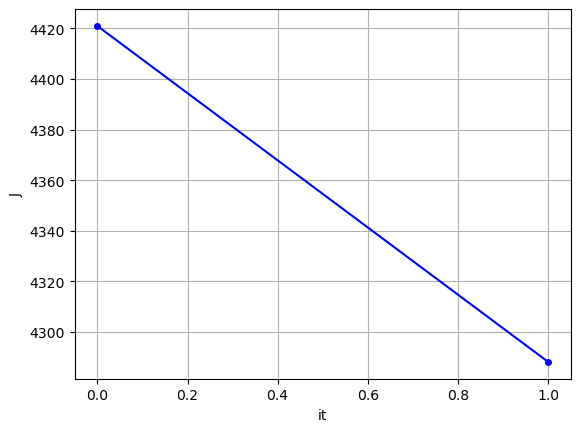

In [15]:
# Define model parameters
input_size = 257  # For example, number of frequency bins in STFT (assuming 512 FFT size, 257 bins for half)
hidden_size = 514  # Hidden layer size
output_size = 257  # Output has the same size as input spectrogram (257 bins)
num_epochs = 2
learning_rate = 0.001

# Instantiate the model
model = Net1(input_size, hidden_size, output_size)

# Train the model
train_model(model, audio_dataloader, num_epochs=num_epochs, learning_rate=learning_rate)


In [13]:
print(len(audio_dataloader))

4


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


torch.Size([257, 501])
torch.Size([501, 257])


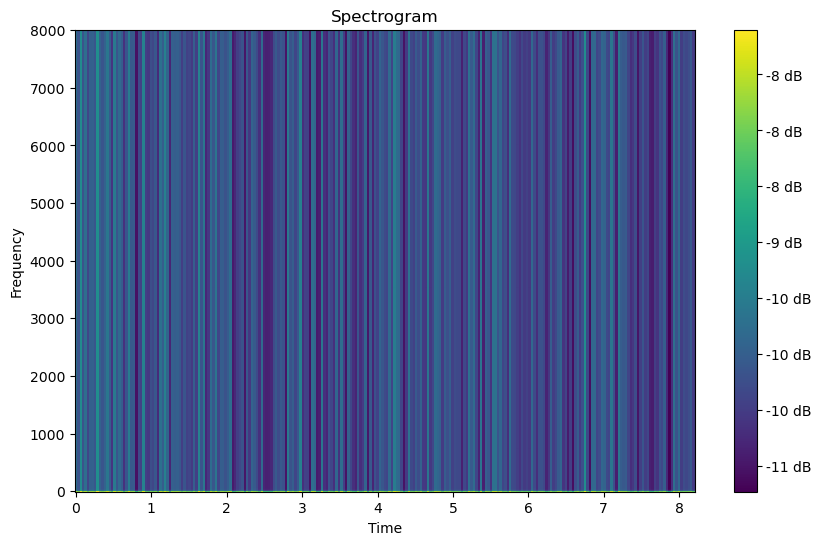

In [10]:
import matplotlib.pyplot as plt
print(noisy_batch[1,:,:].shape)
out_model = model(noisy_batch[1,:,:].transpose(0,1))
print(out_model.shape)
plt.figure(figsize=(10, 6))
librosa.display.specshow(out_model.detach().numpy(), sr=SAMPLE_RATE, x_axis='time', y_axis='hz', cmap='viridis')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

